In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import mdtraj
from deep_boltzmann.networks.training import MLTrainer, FlexibleTrainer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet
from deep_boltzmann.openmmutils import save_latent_samples_as_trajectory
from deep_boltzmann.models.openmm import OpenMMEnergy
import mdtraj as md
from simtk import openmm, unit

import sys, os, shutil
import tensorflow as tf

In [2]:
pdb_model = mdtraj.load_pdb('pdz3_rat_apo_fixed.pdb')

In [3]:
traj = mdtraj.load("traj.h5")
sim_x = traj.xyz
print(sim_x.shape)

(100000, 1655, 3)


In [19]:
print(tf.__version__)

2.5.0


### Auxilliary Function

In [4]:
def setup_protein(pdbmodel_dir):
    """ Sets up protein Topology and Energy Model

    Returns
    -------
    top : mdtraj Topology object
        Protein topology
    energy : Energy object
        Energy model

    """
    # 4C in KIW's experiment
    INTEGRATOR_ARGS = (277*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)

    from simtk.openmm import app
    pdb = app.PDBFile(pdbmodel_dir)
    forcefield = openmm.app.ForceField('amber14/protein.ff14SB.xml', 'amber14/tip3p.xml')

    system = forcefield.createSystem(pdb.topology,removeCMMotion=False,
                                     nonbondedMethod=app.CutoffNonPeriodic, nonbondedCutoff=1.0*unit.nanometers,
                                     constraints=None, rigidWater=True)
    integrator = openmm.LangevinIntegrator(277*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    simulation = openmm.app.Simulation(pdb.topology, system, integrator)

    protein_omm_energy = OpenMMEnergy(system,
                                   openmm.LangevinIntegrator,
                                   unit.nanometers,
                                   n_atoms=md.Topology().from_openmm(simulation.topology).n_atoms,
                                   openmm_integrator_args=INTEGRATOR_ARGS)

    mdtraj_topology = md.Topology().from_openmm(pdb.topology)
    return mdtraj_topology, protein_omm_energy

In [5]:
def get_indices(top, cartesian_CYS=True):
    """ Returns Cartesian and IC indices

    Returns
    -------
    cart : array
        Cartesian atom selection
    Z : array
        Z index matrix

    """
    from deep_boltzmann.models.proteins import mdtraj2Z
    cartesian = ['CA', 'C', 'N']
    cart = top.select(' '.join(["name " + s for s in cartesian]))
    if cartesian_CYS:
        Z_, _carts = mdtraj2Z(top,  cartesian="resname CYS and mass>2 and sidechain")
        Z_ = np.array(Z_)
        cart = np.sort(np.concatenate((cart,_carts)))
    else:
        Z_ = np.array(mdtraj2Z(top))
    return cart, Z_

In [6]:
def train_ML(bg, xtrain, epochs, batch_sizes):
    trainer_ML = MLTrainer(bg, lr=0.001)
    for batch_size in batch_sizes:
        trainer_ML.train(xtrain, epochs=epochs, batch_size=batch_size)
    return trainer_ML

In [13]:
def train_KL(bg, xtrain, epochs, high_energies, w_KLs, stage=0, rc_dims=None, rc_func=None, rc_min=None, 
             rc_max=None, w_RC=0., w_L2_angle=0.):
    trainers_KL_state3 = []
    for current_stage in range(stage, len(epochs)):
        print('-----------------------')
        print(high_energies[current_stage], w_KLs[current_stage])
        sys.stdout.flush()
        flextrainer = FlexibleTrainer(bg, lr=0.0001, batch_size=2000,
                                      high_energy=high_energies[current_stage], max_energy=1e20,
                                      w_KL=w_KLs[current_stage], w_ML=1, weigh_ML=False, w_RC=w_RC,
                                      rc_func=rc_func, rc_min=np.array(rc_min), rc_max=np.array(rc_max),
                                      w_L2_angle=w_L2_angle, 
                                      rc_dims=rc_dims)
        flextrainer.train(xtrain, epochs=epochs[current_stage])
        trainers_KL_state3.append(flextrainer)

        # Analyze
        samples_z = np.random.randn(2000, bg.dim)
        samples_x = bg.Tzx.predict(samples_z)[0]
        samples_e = bg.energy_model.energy(samples_x)
        energy_violations = [np.count_nonzero(samples_e > E) for E in high_energies]
        print('Energy violations:')
        for E, V in zip(high_energies, energy_violations):
            print(V, '\t>\t', E)
        sys.stdout.flush()

        # SAVE
        bg.save('./BG_intermediate_model_saved_TF2.pkl')
        saveconfig = {}
        saveconfig['stage'] = current_stage
        #np.savez_compressed('config_save.npz', **saveconfig)
        print('Intermediate result saved')
        sys.stdout.flush()
    return trainers_KL_state3

### Set up a BG network

In [8]:
top, mm_pdz = setup_protein('pdz3_rat_apo_fixed.pdb')

In [9]:
# Superimpose frames and reshuffle 
nframes = sim_x.shape[0]
dim = sim_x.shape[1]*sim_x.shape[2]
sim_x_traj = mdtraj.Trajectory(sim_x.reshape((nframes, int(dim/3), 3)), top)
sim_x_traj = sim_x_traj.superpose(sim_x_traj[0], atom_indices=top.select('backbone'))
sim_x = sim_x_traj.xyz.reshape((nframes, -1))
np.random.shuffle(sim_x)

In [10]:
# Get indices for dimensions represented by cartesian and internal coordinates respectively
CartIndices, ZIndices = get_indices(top, cartesian_CYS=False)

In [11]:
# Construct Boltzmann Generator object 
bg = invnet(dim, 'R'*8, energy_model=mm_pdz,
            ic=np.asarray(ZIndices,dtype=np.int), ic_cart=np.asarray(CartIndices,dtype=np.int), ic_norm=sim_x,
            nl_layers=4, nl_hidden=[256, 128, 256], nl_activation='relu', nl_activation_scale='tanh')
print('BG constructed\n')
sys.stdout.flush()

I<RRRRRRRR>
I 4965 0 0
< 4959 0 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
> 2480 2479 6
Before connect
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Done xz
Done zx
BG constructed



### ML training with MD-generated Dataset

In [12]:
# Perform ML training -- Three epochs with increasing batch sizes
epochs_ML = 200
batch_sizes_ML = [128, 256, 512]
train_ML(bg, sim_x, epochs_ML, batch_sizes_ML)
bg.save('./BG_save_after_ML_TF2.pkl')

print('ML training done\n')
sys.stdout.flush()

Epoch 0/200 ML Loss Value -18137.3906 
Epoch 1/200 ML Loss Value -18698.8320 
Epoch 2/200 ML Loss Value -18723.2031 
Epoch 3/200 ML Loss Value -18760.0820 
Epoch 4/200 ML Loss Value -18814.3223 
Epoch 5/200 ML Loss Value -18843.3145 
Epoch 6/200 ML Loss Value -18897.3008 
Epoch 7/200 ML Loss Value -18899.9629 
Epoch 8/200 ML Loss Value -18878.8359 
Epoch 9/200 ML Loss Value -18935.3301 
Epoch 10/200 ML Loss Value -18906.4570 
Epoch 11/200 ML Loss Value -18909.7109 
Epoch 12/200 ML Loss Value -18933.2070 
Epoch 13/200 ML Loss Value -18924.6562 
Epoch 14/200 ML Loss Value -18923.1641 
Epoch 15/200 ML Loss Value -18925.5781 
Epoch 16/200 ML Loss Value -18937.4355 
Epoch 17/200 ML Loss Value -18930.4434 
Epoch 18/200 ML Loss Value -18962.1230 
Epoch 19/200 ML Loss Value -18937.0273 
Epoch 20/200 ML Loss Value -18941.7285 
Epoch 21/200 ML Loss Value -18916.8242 
Epoch 22/200 ML Loss Value -18939.5410 
Epoch 23/200 ML Loss Value -18952.2383 
Epoch 24/200 ML Loss Value -18943.7344 
Epoch 25/2

### KL + ML Flexible Training

In [11]:
bg = EnergyInvNet.load("./BG_save_after_ML_TF2.pkl", mm_pdz)

Before connect
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Done xz
Done zx


In [12]:
saveconfig = {}
# Train KL
saveconfig['stage'] = 0

epochs_KL     = [  15,   15,   15,   15,   15,   15,  20,  20,  30, 50, 50, 300]
high_energies = [1e10,  1e9,  1e8,  1e7,  1e6,  1e5,  1e5,  1e5,  5e4,  5e4,  2e4,  2e4]
w_KLs         = [1e-12, 1e-6, 1e-5, 1e-4, 1e-3, 1e-3, 5e-3, 1e-3, 5e-3, 5e-2, 0.05, 0.05]
KL_trainer_state = train_KL(bg, sim_x, epochs_KL, high_energies, w_KLs, saveconfig['stage'],w_L2_angle=1.0)


-----------------------
10000000000.0 1e-12
Epoch 0/15 Overall Loss -321.2961 ML Loss -19265.3965 KL Loss 1386229504.0000 L2 Angle Loss 18944.0977 
Epoch 1/15 Overall Loss -4648.3008 ML Loss -19259.2637 KL Loss 1406006400.0000 L2 Angle Loss 14610.9629 
Epoch 2/15 Overall Loss -6738.2129 ML Loss -19258.4609 KL Loss 1351969024.0000 L2 Angle Loss 12520.2490 
Epoch 3/15 Overall Loss -10099.6279 ML Loss -19256.3086 KL Loss 1396531456.0000 L2 Angle Loss 9156.6797 
Epoch 4/15 Overall Loss -11798.9141 ML Loss -19254.2070 KL Loss 1198661888.0000 L2 Angle Loss 7455.2910 
Epoch 5/15 Overall Loss -13413.2861 ML Loss -19245.1191 KL Loss 1323009920.0000 L2 Angle Loss 5831.8320 
Epoch 6/15 Overall Loss -14244.8652 ML Loss -19246.8867 KL Loss 1446925184.0000 L2 Angle Loss 5002.0210 
Epoch 7/15 Overall Loss -14937.7539 ML Loss -19237.6191 KL Loss 1443429888.0000 L2 Angle Loss 4299.8628 
Epoch 8/15 Overall Loss -15648.5898 ML Loss -19227.7812 KL Loss 1407626624.0000 L2 Angle Loss 3579.1907 
Epoch 9/15 O

NameError: name 'trainers_KL_state' is not defined

### Visualization

In [14]:
%%time
zsamples, xsamples, zenergys, xenergys, logw = bg.sample(nsample=10000)

CPU times: user 1min 14s, sys: 41.5 s, total: 1min 56s
Wall time: 27.8 s


In [26]:
xsamples, Jzx = bg.transform_zxJ(zsamples)
xenergys = bg.energy_model.energy(xsamples) / 1.0

In [32]:
logw = -xenergys + zenergys + Jzx[:,0]

In [15]:
from IPython import display
display.set_matplotlib_formats("svg")

(0.0, 5000.0)

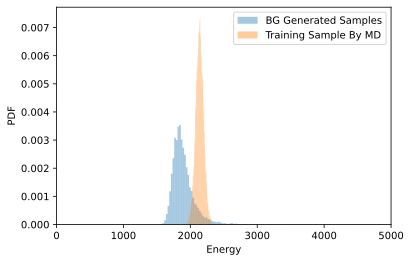

In [31]:
plt.hist(xenergys[xenergys<5000],bins=128,density=True,alpha=0.4, label="BG Generated Samples");
plt.hist(mm_pdz.energy(sim_x[::10,:]), bins=128,density=True,alpha=0.4, label='Training Sample By MD');
plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend()
plt.xlim(0,5000)

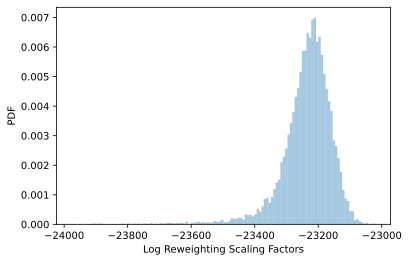

In [48]:
plt.hist(logw[logw>-24000], bins=128, density=True, alpha=0.4, label="Reweighting Scaling Factors")
plt.xlabel("Log Reweighting Scaling Factors")
plt.ylabel("PDF")
plt.show()

#### "Higher Temperature"

In [54]:
zsamples_2, xsamples_2, zenergys_2, xenergys_2, _ = bg.sample(temperature=1.5, nsample=10000)

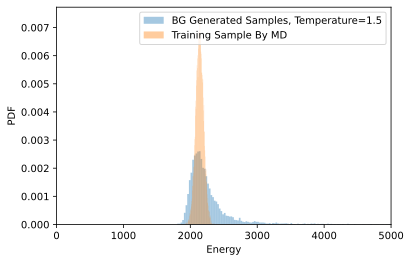

In [56]:
plt.hist(xenergys_2[xenergys_2<5000],bins=128,density=True,alpha=0.4, label="BG Generated Samples, Temperature=1.5");
plt.hist(mm_pdz.energy(sim_x[::10,:]), bins=128,density=True,alpha=0.4, label='Training Sample By MD');
plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend()
plt.xlim(0,5000)
plt.show()

In [71]:
w_tail = np.argwhere((xenergys_2 > 2400) & (xenergys_2 < 3000)).reshape(-1)

In [73]:
w_tail.shape

(1394,)

### Save As PDB files

In [37]:
save_latent_samples_as_trajectory(xsamples[225], top, filename="BGTF2_pdz3_sample.pdb")

<mdtraj.Trajectory with 1 frames, 1655 atoms, 110 residues, without unitcells at 0x7fcb87576710>

In [38]:
save_latent_samples_as_trajectory(xsamples[1000:1500], top, filename="BGTF2_pdz3_batchsample.pdb")

<mdtraj.Trajectory with 500 frames, 1655 atoms, 110 residues, without unitcells at 0x7fcb87565390>

In [41]:
save_latent_samples_as_trajectory(sim_x[1000:1500], top, filename="MD_pdz3_batchsample.pdb")

<mdtraj.Trajectory with 500 frames, 1655 atoms, 110 residues, without unitcells at 0x7fcb87552e10>

In [46]:
mm_pdz.energy(sim_x[5000].reshape(1,-1))

array([2199.3096], dtype=float32)

In [47]:
save_latent_samples_as_trajectory(sim_x[5000], top, filename="MD_pdz3_sample.pdb")

<mdtraj.Trajectory with 1 frames, 1655 atoms, 110 residues, without unitcells at 0x7fcb8753b650>

In [62]:
save_latent_samples_as_trajectory(xsamples_2[120], top, filename="BGTF2_1p5T_pdz3_sample.pdb")

<mdtraj.Trajectory with 1 frames, 1655 atoms, 110 residues, without unitcells at 0x7fcac6cfdc50>

In [63]:
save_latent_samples_as_trajectory(xsamples_2[1000:1500], top, filename="BGTF2_1p5T_pdz3_batchsample.pdb")

<mdtraj.Trajectory with 500 frames, 1655 atoms, 110 residues, without unitcells at 0x7fcac6d233d0>

In [74]:
save_latent_samples_as_trajectory(xsamples_2[w_tail[0:500]], top, filename="BGTF2_1p5T_pdz3_tailbatchsample.pdb")

<mdtraj.Trajectory with 500 frames, 1655 atoms, 110 residues, without unitcells at 0x7fcac7aa2950>

---

## Dev Details (Endless DeBugging Journey....)

### 3. Fix ML Training loss explosion

In [13]:
model = bg.Txz

In [14]:
x_batch = sim_x[10:20]

In [15]:
output_z1, log_det_Jxz = model(x_batch)

In [19]:
log_det_Jxz

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[26349.822],
       [26264.479],
       [26328.836],
       [26314.508],
       [26325.656],
       [26336.379],
       [26344.482],
       [26367.89 ],
       [26299.105],
       [26346.39 ]], dtype=float32)>

In [22]:
std=1.0
loss_value = -tf.reduce_mean(tf.reshape(log_det_Jxz, -1) + (0.5 / (std**2)) * tf.reduce_sum(output_z1**2, axis=1))

In [23]:
loss_value

<tf.Tensor: shape=(), dtype=float32, numpy=-10806915000000.0>

In [20]:
output_z2 = bg.connect_xz(x_batch)

In [21]:
log_det_xz = bg.log_det_xz

In [22]:
output_z1

<tf.Tensor: shape=(10, 4965), dtype=float32, numpy=
array([[-0.38572043,  1.0874743 ,  1.0970479 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27067822,  1.7654368 , -1.0395395 , ...,  0.        ,
        -0.        ,  0.        ],
       [-0.0649422 ,  1.3580017 ,  0.11092915, ..., -0.        ,
         0.        ,  0.        ],
       ...,
       [-1.1983048 , -0.18631643,  2.1536243 , ...,  0.        ,
        -0.        , -0.        ],
       [ 0.4923452 ,  1.4864125 , -0.48126477, ...,  0.        ,
         0.        , -0.        ],
       [-0.1368334 ,  0.74937445,  1.8363332 , ..., -0.        ,
        -0.        , -0.        ]], dtype=float32)>

In [23]:
output_z2

<tf.Tensor: shape=(10, 4965), dtype=float32, numpy=
array([[-0.38572043,  1.0874743 ,  1.0970479 , ...,  0.        ,
         0.        , -0.        ],
       [ 0.27067822,  1.7654368 , -1.0395395 , ..., -0.        ,
        -0.        ,  0.        ],
       [-0.0649422 ,  1.3580017 ,  0.11092915, ..., -0.        ,
         0.        , -0.        ],
       ...,
       [-1.1983048 , -0.18631643,  2.1536243 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4923452 ,  1.4864125 , -0.48126477, ...,  0.        ,
        -0.        , -0.        ],
       [-0.1368334 ,  0.74937445,  1.8363332 , ...,  0.        ,
        -0.        , -0.        ]], dtype=float32)>

In [24]:
log_det_Jxz

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[21480.055],
       [21480.73 ],
       [21481.84 ],
       [21476.578],
       [21476.934],
       [21476.277],
       [21478.172],
       [21483.027],
       [21481.965],
       [21482.008]], dtype=float32)>

In [28]:
output_z3, log_det_Jxz2 = model(sim_x[100:110])

In [29]:
log_det_Jxz2

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[21481.18 ],
       [21476.781],
       [21479.574],
       [21483.113],
       [21479.   ],
       [21476.969],
       [21479.61 ],
       [21482.496],
       [21479.445],
       [21485.316]], dtype=float32)>

In [36]:
with tf.GradientTape() as tape:
    x_batch_tensor = tf.constant(x_batch)
    tape.watch(x_batch_tensor)
    output_z1 = bg.connect_xz(x_batch_tensor)
exp_batch_jacobian = tape.batch_jacobian(x_batch_tensor, output_z1)

In [26]:
std=1.0
termb = (0.5 / (std**2)) * tf.reduce_sum(output_z1*2, axis=1)

In [39]:
x_batch_tensor

<tf.Tensor: shape=(10, 4965), dtype=float32, numpy=
array([[1.1377395 , 6.385933  , 1.9510151 , ..., 2.077936  , 7.79715   ,
        0.6050656 ],
       [1.149987  , 6.3996863 , 1.9762697 , ..., 2.0196128 , 7.7790155 ,
        0.5844537 ],
       [1.062763  , 6.438077  , 1.9809059 , ..., 2.0458288 , 7.784514  ,
        0.63181514],
       ...,
       [1.0283183 , 6.361233  , 2.0309546 , ..., 2.0416245 , 7.777888  ,
        0.5608026 ],
       [0.9863261 , 6.389696  , 1.9534181 , ..., 2.0709953 , 7.802592  ,
        0.66664684],
       [1.0502871 , 6.3820953 , 1.9742559 , ..., 2.078636  , 7.8125362 ,
        0.6428285 ]], dtype=float32)>

In [45]:
with tf.GradientTape() as tape:
    output_z, log_det_Jxz = bg.Txz(x_batch)
    loss_value = -tf.reshape(log_det_Jxz, -1) + (0.5 / (std**2)) * tf.reduce_sum(output_z*2, axis=1)

In [42]:
grads = tape.gradient(loss_value, bg.Txz.trainable_weights)

In [50]:
grads

[<tf.Tensor: shape=(2480, 256), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(256,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

In [48]:
grads2 = tape.gradient(loss_value, bg.Txz.trainable_weights)

In [49]:
grads2

[<tf.Tensor: shape=(2480, 256), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(256,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [51]:
optimizer.apply_gradients(zip(grads, bg.Txz.trainable_weights))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [52]:
with tf.GradientTape() as tape:
    output_z, log_det_Jxz = bg.Txz(x_batch)
    loss_value = -tf.reshape(log_det_Jxz, -1) + (0.5 / (std**2)) * tf.reduce_sum(output_z**2, axis=1)

In [53]:
loss_value

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-22139.494, -22143.205, -22142.703, -22028.975, -22046.398,
       -22201.07 , -22124.742, -22242.014, -22052.213, -22209.117],
      dtype=float32)>

In [62]:
std=1.0
def train_step():
    with tf.GradientTape() as tape:
        output_z, log_det_Jxz = bg.Txz(x_batch)
        loss_value = -tf.reshape(log_det_Jxz, -1) + (0.5 / (std**2)) * tf.reduce_sum(output_z**2, axis=1)
    grads = tape.gradient(loss_value, bg.Txz.trainable_weights)
    optimizer.apply_gradients(zip(grads, bg.Txz.trainable_weights))
    return tf.reduce_mean(loss_value)

In [67]:
N = sim_x.shape[0]
I = np.arange(N)
batch_size=30
for i in range(20):
    x_batch = sim_x[np.random.choice(I, size=batch_size, replace=True)]
    loss_value = train_step()
    print(i, float(loss_value))

0 -17284.2734375
1 -17387.373046875
2 -17371.86328125
3 -17446.16796875
4 -17449.25
5 -17485.83203125
6 -17540.01171875
7 -17505.66796875
8 -17619.857421875
9 -17662.029296875
10 -17708.044921875
11 -17755.962890625
12 -17760.888671875
13 -17785.76171875
14 -17798.77734375
15 -17826.521484375
16 -17835.763671875
17 -17886.8828125
18 -17982.849609375
19 -17933.603515625


In [58]:
output_z, log_det_Jxz = bg.Txz(sim_x[:10])

In [59]:
log_det_Jxz

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[27223.412],
       [27199.78 ],
       [27200.182],
       [27242.35 ],
       [27216.387],
       [27188.66 ],
       [27274.74 ],
       [27204.965],
       [27214.15 ],
       [27164.537]], dtype=float32)>

In [60]:
(0.5 / (std**2)) * tf.reduce_sum(output_z*2, axis=1)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-37777612., -34213810., -39646144., -35831170., -43469420.,
       -33062608., -36654610., -35923024., -35778720., -33701932.],
      dtype=float32)>

### 2. Fix keras ML Training

In [19]:
model = bg.Txz

In [22]:
y = np.zeros((10, bg.dim))

In [23]:
# This line can reproduce the above issue
model.train_on_batch(x=sim_x[:10],y=y)

TypeError: in user code:

    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/training.py:830 train_function  *
        return step_function(self, iterator)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/training.py:813 run_step  *
        outputs = model.train_step(data)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/training.py:771 train_step  *
        loss = self.compiled_loss(
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/compile_utils.py:239 __call__  *
        self._loss_metric.update_state(
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/metrics.py:169 decorated  *
        update_op = update_state_fn(*args, **kwargs)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/metrics.py:155 update_state_fn  *
        return ag_update_state(*args, **kwargs)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/metrics.py:386 update_state  *
        sample_weight = tf.__internal__.ops.broadcast_weights(
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/ops/weights_broadcast_ops.py:157 broadcast_weights  **
        values = ops.convert_to_tensor(values, name="values")
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1566 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:265 constant
        allow_broadcast=True)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:283 _constant_impl
        allow_broadcast=allow_broadcast))
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:435 make_tensor_proto
        values = np.asarray(values)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/numpy/core/_asarray.py:83 asarray
        return array(a, dtype, copy=False, order=order)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/keras_tensor.py:245 __array__
        'Cannot convert a symbolic Keras input/output to a numpy array. '

    TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.


In [27]:
# This line can also reproduce the above issue
model.fit(x=sim_x[:10],y=y, batch_size=10)

TypeError: in user code:

    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/training.py:830 train_function  *
        return step_function(self, iterator)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/training.py:813 run_step  *
        outputs = model.train_step(data)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/training.py:771 train_step  *
        loss = self.compiled_loss(
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/compile_utils.py:239 __call__  *
        self._loss_metric.update_state(
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/metrics.py:169 decorated  *
        update_op = update_state_fn(*args, **kwargs)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/metrics.py:155 update_state_fn  *
        return ag_update_state(*args, **kwargs)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/metrics.py:386 update_state  *
        sample_weight = tf.__internal__.ops.broadcast_weights(
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/ops/weights_broadcast_ops.py:157 broadcast_weights  **
        values = ops.convert_to_tensor(values, name="values")
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1566 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:265 constant
        allow_broadcast=True)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:283 _constant_impl
        allow_broadcast=allow_broadcast))
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:435 make_tensor_proto
        values = np.asarray(values)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/numpy/core/_asarray.py:83 asarray
        return array(a, dtype, copy=False, order=order)
    /opt/miniconda3/envs/rs/lib/python3.7/site-packages/keras/engine/keras_tensor.py:245 __array__
        'Cannot convert a symbolic Keras input/output to a numpy array. '

    TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.


In [13]:
x_batch = sim_x[:10]

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

Do the following modification:

```
self.Txz = tf.keras.models.Model(inputs=self.input_x, outputs=[self.output_z, self.log_det_Jxz])
self.Tzx = tf.keras.models.Model(inputs=self.input_z, outputs=[self.output_x, self.log_det_Jzx])
```

In [14]:
output_z, log_det_Jxz = bg.Txz(x_batch)

In [48]:
std=1.0
def train_step():
    with tf.GradientTape() as tape:
        output_z, log_det_Jxz = bg.Txz(x_batch)
        loss_value = -tf.reduce_mean(tf.reshape(log_det_Jxz, -1) - (0.5 / (std**2)) * tf.reduce_sum(output_z*2, axis=1))
    grads = tape.gradient(loss_value, bg.Txz.trainable_weights)
    optimizer.apply_gradients(zip(grads, bg.Txz.trainable_weights))
    return loss_value

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [50]:
for i in range(10):
    loss_value = train_step()
    print(i, float(loss_value))

0 -21506.26171875
1 -22121.1171875
2 -22846.787109375
3 -23775.875
4 -25000.630859375
5 -26654.53515625
6 -28954.54296875
7 -32282.974609375
8 -37331.953125
9 -45358.421875


### 1. Fix Keras

In [13]:
import keras

In [17]:
opt = keras.optimizer_v2.adam.Adam(learning_rate=0.01, clipnorm=True)

In [ ]:
tf.keras.optimizers.Adam()

In [14]:
keras.__version__

'2.5.0'

In [ ]:
keras.models.Model()

In [ ]:
tf.keras.models.Model()

In [15]:
tf.__version__

'2.5.0'

In [ ]:
tf.keras.Model()

In [ ]:
tf.keras.layers.Input()

In [ ]:
tf.keras.layers.Add()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
tf.keras.backend.eval()

In [ ]:
tf.keras.layers.Lambda()

In [ ]:
tf.keras.layers.Concatenate()

In [ ]:
tf.keras.layers.Layer

In [ ]:
tf.keras.backend.floatx()

In [ ]:
tf.keras.layers.Subtract()

In [ ]:
tf.keras.layers.Multiply()

In [ ]:
tf.keras.layers.Dense()

In [ ]:
tf.keras.initializers.Zeros()

In [ ]:
tf.keras.backend.dot()

In [16]:
tf.__version__

'2.5.0'

In [ ]:
tf.keras.utils.model_to_dot()

In [ ]:
tf.keras.layers.deserialize()

In [18]:
tf.keras.backend.learning_phase()

0

In [ ]:
tf.keras.backend.function()

In [17]:
np.__version__

'1.19.2'